# Problem

\begin{equation}
  \partial_tu - \nabla\cdot K(\nabla u)\nabla u = f
\end{equation}
$f=f(x,t)$ is a time dependent forcing term and
the diffusion tensor is
\begin{equation}
  K(u) = \frac{2}{1+\sqrt{1+4|\nabla u|}}
\end{equation}
On the boundary we prescribe Neumann boundary conditions and
require initial conditions $u(\cdot,0)=u_0(\cdot)$.

We solve this problem in variational form using Implicit Euler in time
\begin{align*}
\int_{\Omega} &\frac{u^{n+1}-u^n}{\Delta t} v
+ K(u^{n+1}) \nabla u^{n+1} \cdot \nabla v \; dx
= \int_{\Omega} f(x,t^n+\Delta t) v\; dx
  + \int_{\partial \Omega} g(x,t^n+\Delta t)\cdot n \; v\; ds~.
\end{align*}
on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution is
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}

Setup grid and space

In [1]:
import numpy as np
from dune.grid import cartesianDomain
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem import integrate

domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view = leafGridView(domain)
space = solutionSpace(view, order=2)

DUNE-INFO: Generating dune-py module in /home/mgern/finite_elemente/duneproject/.cache/dune-py
DUNE-INFO: Compiling HierarchicalGrid (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: Compiling Space (new)


Import UFL variables and define spatial coordinate, test/trial function

In [2]:
from dune.ufl import DirichletBC, Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate,\
      FacetNormal, dx, ds, div, grad, dot, inner, sqrt, exp, sin

x = SpatialCoordinate(space)
n = FacetNormal(space)
u = TrialFunction(space)
v = TestFunction(space)

Define initial condition and exact solution

In [3]:
initial = 1/2*(x[0]**2+x[1]**2)-1/3*(x[0]**3-x[1]**3)+1
exact   = lambda t: exp(-2*t)*(initial - 1) + 1
dtExact = lambda s: -2*exp(-2*s)*(initial - 1)

Define discrete functions, one for $u^{n+1}$ and one for $u^n$.
We also define two constants which can be used as floats in
ufl expressions but can be changed at a later stage without requiring
any recompilation.

In [ ]:
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time

u_h   = space.interpolate(exact(t), name='u_h')
u_h_n = u_h.copy(name="previous")

Now setup the model and the scheme:
\[
\begin{align*}
\int_{\Omega} &\frac{u^{n+1}-u^n}{\Delta t} v
+ K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla v \; dx
= \int_{\Omega} f(x,t^n+\Delta t) v\; dx
  + \int_{\partial \Omega} g(x,t^n+\Delta t)\cdot n \; v\; ds~.
\end{align*}
\]

In [10]:
abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
f = lambda t: dtExact(t) - div( K(exact(t))*grad(exact(t)))
g = lambda t: K(exact(t))*grad(exact(t))


## Task
Implement the form __a__ and right hand side __b__ as described above, using
terms $K$, $f$, and $g$.

In [11]:
##### TASK
a = inner(u-u_h_n,v)/dt * dx +  K(u) * inner(grad(u), grad(v)) * dx
b = f(t + dt) * v * dx + inner(g(t+dt), n) * v * ds


A Galerkin scheme is created that allows us to solve the equation $a=b$.

In [12]:
scheme = solutionScheme(a == b, solver='cg')

DUNE-INFO: Compiling Integrands (new)
DUNE-INFO: Compiling Scheme (new)


Time loop: first choose a time step and then iterate
from $t^0=0$ to $t^N=N\Delta t =0.25$.
We write vtk files every after every 0.05 time interval.

In [21]:
scheme.model.dt = 0.0025
saveInterval = 0.05
vtk = view.sequencedVTK("parabolic", pointdata=[u_h])
nextSaveTime = saveInterval
vtk()

time = 0
endTime = 0.25
while time <= endTime:
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += scheme.model.dt
    scheme.model.t = time
    if time >= nextSaveTime or time >= endTime:
        vtk()
        nextSaveTime += saveInterval

Plot result and compute error

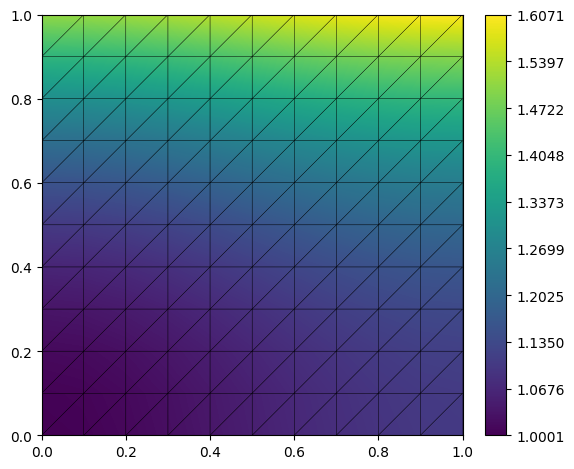

error at final time= 0.16351780582289657


In [19]:
u_h.plot()

error = dot(u_h-exact(t),u_h-exact(t))
error = np.sqrt( integrate(error, view, order=5) )
print("error at final time=", error)